# Import the needed packages

In [54]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Loading the data

In [2]:
df_march = pd.read_csv('./data/yellow_tripdata_2017-03.csv')  
df_june = pd.read_csv('./data/yellow_tripdata_2017-06.csv')  
df_nov = pd.read_csv('./data/yellow_tripdata_2017-11.csv') 
df = pd.concat([df_march, df_june, df_nov])
#df = df_march

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


In [4]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [5]:
df.shape

(29236424, 17)

# Analizing the data set

In [6]:
# we check the nulls or missing values on each variable
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

First of all, we are going to analize some important variables than we can suppose that affect to our target variable (in this case, the tip of the trip)

### Distances of the trips

In [7]:
df['trip_distance'].describe()

count    2.923642e+07
mean     2.919386e+00
std      4.476535e+00
min      0.000000e+00
25%      9.700000e-01
50%      1.600000e+00
75%      3.010000e+00
max      9.496980e+03
Name: trip_distance, dtype: float64

In [8]:
trip_dis = df['trip_distance']

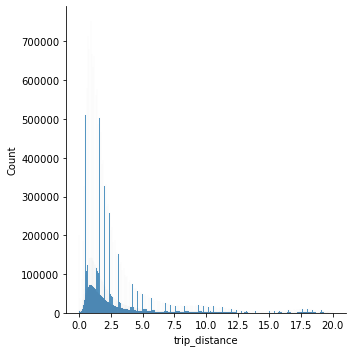

In [9]:
# we plot distances lower than 20 
sns.displot(trip_dis[trip_dis <= 20]) 

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_distance'>

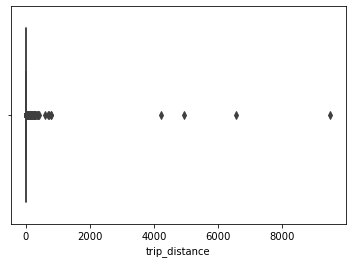

In [10]:
sns.boxplot(df['trip_distance'])

In [53]:
df['trip_distance'].quantile(0.95)

3.53

In [12]:
df = df[df.trip_distance <= df['trip_distance'].quantile(0.95)]

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_distance'>

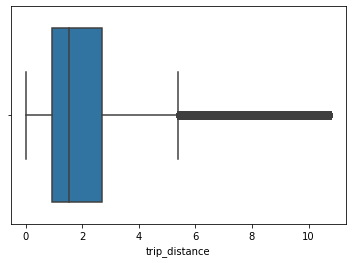

In [13]:
sns.boxplot(df['trip_distance'])

### Date and time

Now we are going to analize the dates and hours in which the trips are done. To do that, we are going to compute some new variables we can think that it will be important for the moder. For example, the duration of the trip, the they of the week, or the momento of the day

In [14]:
df.loc[:,'time_pick'] = pd.to_datetime(df['tpep_pickup_datetime'])
df.loc[:,'time_drop'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df.loc[:,'time_delta'] = (df['time_drop'] - df['time_pick']).astype('timedelta64[m]')
df.loc[:,'dow'] = df.time_pick.dt.dayofweek
df.loc[:,'is_weekend'] = [ 1 if x >= 5 else 0  for x in df.dow]

In [15]:
def get_moment_of_day(x):
    if x.hour >= 8 and x.hour < 13:
        return 'morning'
    elif x.hour >= 13 and x.hour < 19:
        return 'evening'
    else:
        return 'night'
df.loc[:,'moment_day'] = df.time_pick.apply(lambda x: get_moment_of_day(x))

In [16]:
df[['time_pick', 'time_drop','time_delta', 'dow', 'is_weekend', 'moment_day']].head()

,time_pick,time_drop,time_delta,dow,is_weekend,moment_day
0,2017-03-09 21:30:11,2017-03-09 21:44:20,14.0,3,0,night
1,2017-03-09 21:47:00,2017-03-09 21:58:01,11.0,3,0,night
2,2017-03-09 22:01:08,2017-03-09 22:11:16,10.0,3,0,night
3,2017-03-09 22:16:05,2017-03-10 06:26:11,490.0,3,0,night
4,2017-03-31 06:31:53,2017-03-31 06:41:48,9.0,4,0,night


In [17]:
df.time_delta.describe()

count    2.777490e+07
mean     1.473425e+01
std      1.541913e+02
min     -6.000000e+01
25%      6.000000e+00
50%      1.000000e+01
75%      1.700000e+01
max      7.577710e+05
Name: time_delta, dtype: float64

As we can appreciate on the summary of the variable that represent the minutes of each trip, there are some negatives durations, so we can clean it and analize the variable

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_delta'>

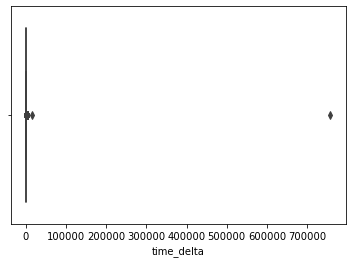

In [18]:
sns.boxplot(df.time_delta)

In [19]:
df.time_delta.quantile(.95)

30.0

In [20]:
df = df[(df.time_delta >= 0) & (df.time_delta <= df.time_delta.quantile(.95))]

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_delta'>

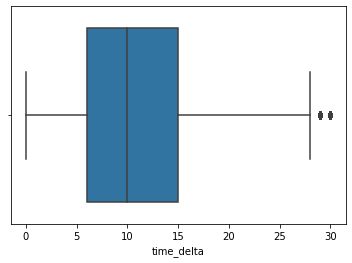

In [21]:
sns.boxplot(df.time_delta)

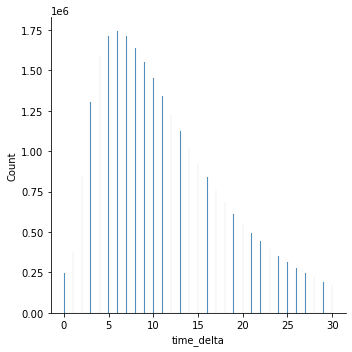

In [22]:
sns.displot(df.time_delta)

### Tip amount

In [23]:
df['tip_amount'].describe()

count    2.639340e+07
mean     1.476812e+00
std      1.771573e+00
min     -1.120000e+02
25%      0.000000e+00
50%      1.260000e+00
75%      2.200000e+00
max      4.500000e+02
Name: tip_amount, dtype: float64

There are negative values, so we proceed to remove them or replace by zeros. Also, we see that there are some tips greater than the others, so we proceed to analize the box plot.

<AxesSubplot:xlabel='tip_amount'>

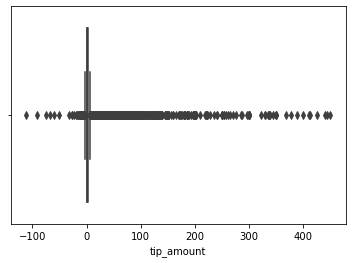

In [24]:
sns.boxplot(x = df['tip_amount'])

We have to clean this variable before to do the model to predict it. To do that, we can considerer the 95th percetile as a top of the variable, and 0 as the minimum value.

In [25]:
df['tip_amount'].quantile(0.95)

4.16

In [26]:
df = df[(df.tip_amount >= 0) & (df.tip_amount <= df['tip_amount'].quantile(0.95))]

<AxesSubplot:xlabel='tip_amount'>

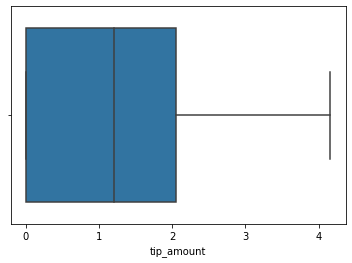

In [27]:
sns.boxplot(x = df['tip_amount'])

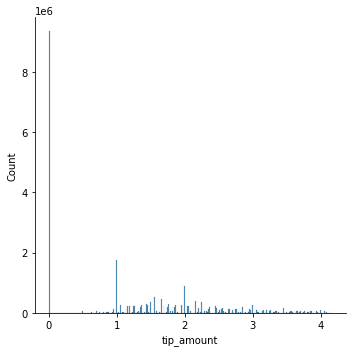

In [28]:
sns.displot(df['tip_amount'])

## Comparative between tips and factor variables

Now we can compare the tip amount for each payment type

In [29]:
tip_paym = df[['payment_type', 'tip_amount']]

In [30]:
tip_paym.groupby('payment_type').describe()#.unstack(1)

tip_amount                                                     
                   count          mean       std  min   25%   50%   75%   max
payment_type                                                                 
1             16475158.0  1.894576e+00  0.909157  0.0  1.24  1.85  2.46  4.16
2              8440992.0  8.174395e-07  0.001336  0.0  0.00  0.00  0.00  3.20
3               137452.0  1.906629e-03  0.059253  0.0  0.00  0.00  0.00  4.16
4                38440.0  2.478668e-03  0.070877  0.0  0.00  0.00  0.00  4.05
5                    1.0  0.000000e+00       NaN  0.0  0.00  0.00  0.00  0.00

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


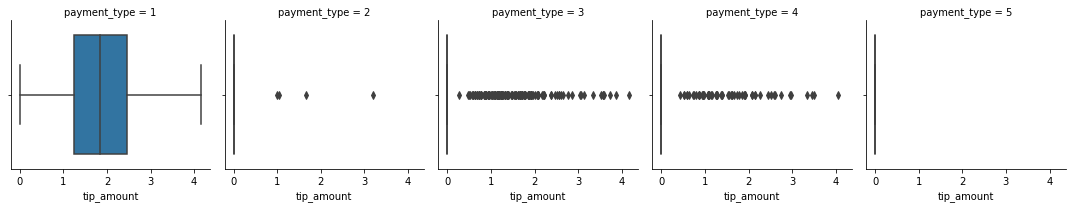

In [31]:
g = sns.FacetGrid(tip_paym, col = "payment_type")
g.map(sns.boxplot, "tip_amount")

If we analize each boxplot, we can observe that the most common payment is with credit card and when this method of pay there are more tips than with the others.

Now we are going to compare the tips with the rate code of the trip.

In [32]:
tip_ratecode = df[['RatecodeID', 'tip_amount']]

In [33]:
tip_ratecode.groupby('RatecodeID').describe()

tip_amount                                               
                 count      mean       std  min  25%  50%   75%   max
RatecodeID                                                           
1           25017047.0  1.246509  1.162439  0.0  0.0  1.2  2.05  4.16
2              21817.0  0.083754  0.492404  0.0  0.0  0.0  0.00  4.10
3               5061.0  0.087084  0.544164  0.0  0.0  0.0  0.00  4.16
4               2705.0  0.360950  0.947586  0.0  0.0  0.0  0.00  4.16
5              44723.0  0.592499  1.091438  0.0  0.0  0.0  1.00  4.16
6                221.0  0.033032  0.289436  0.0  0.0  0.0  0.00  4.00
99               469.0  0.151109  0.642812  0.0  0.0  0.0  0.00  4.05

/Users/sergio/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


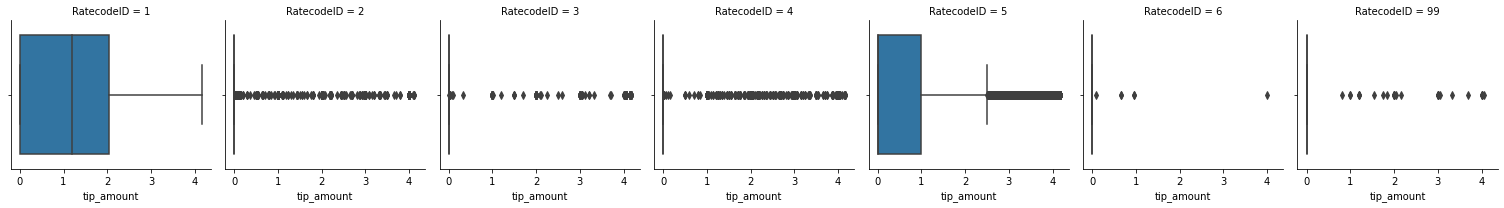

In [34]:
g = sns.FacetGrid(tip_ratecode, col = "RatecodeID")
g.map(sns.boxplot, "tip_amount")

And now, what is the relation between the day and the time of the trip and the tips?

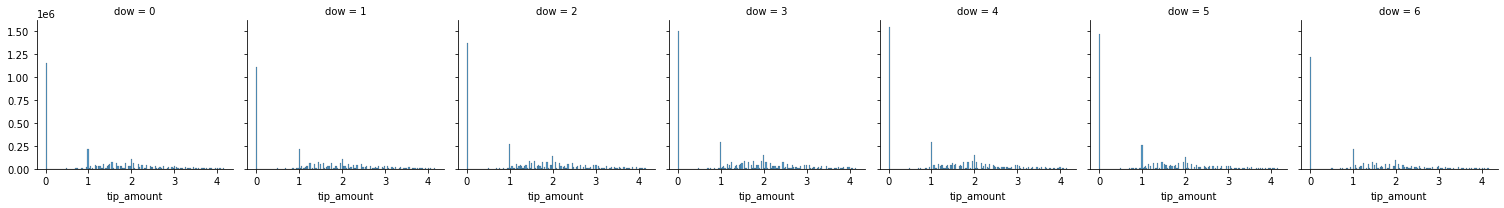

In [35]:
g = sns.FacetGrid(df[['dow', 'tip_amount']], col = "dow")
g.map(sns.histplot, "tip_amount")
plt.show()

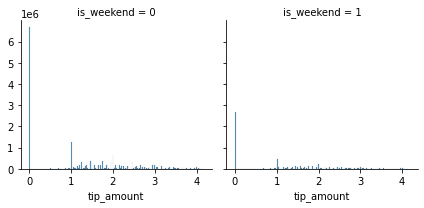

In [36]:
g = sns.FacetGrid(df[['is_weekend', 'tip_amount']], col = "is_weekend")
g.map(sns.histplot, "tip_amount")
plt.show()

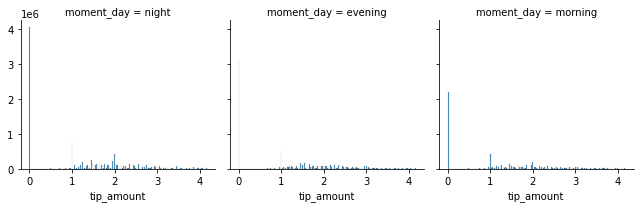

In [37]:
g = sns.FacetGrid(df[['moment_day', 'tip_amount']], col = "moment_day")
#g.map(sns.boxplot, "tip_amount")
g.map(sns.histplot, "tip_amount")

## Correlations

First of all, we are going to drop some variables that we are not going to use to predict the tip amount or that we use it before to define another variables.

In [38]:
df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 
              'time_pick', 'time_drop',
              'PULocationID', 'DOLocationID'], 1, inplace=True)

In [39]:
df.dtypes #== 'int64'

VendorID                   int64
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
time_delta               float64
dow                        int64
is_weekend                 int64
moment_day                object
dtype: object

<AxesSubplot:>

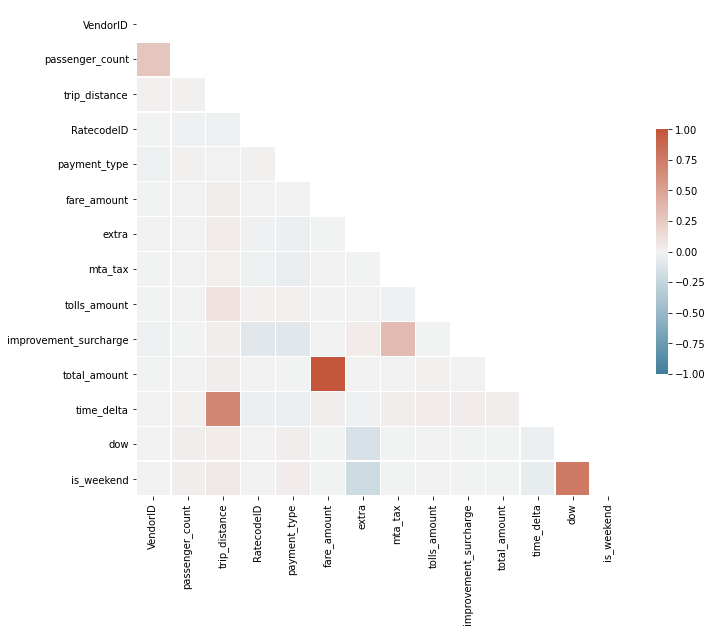

In [40]:
# Compute the correlation matrix
corr = df.drop(['tip_amount'], 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=1, center=0, vmin = -1,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

Analyzing this heat map of the correlations of variables, we can remove some of them due to a high correlation.
- 'dow' variable and 'is_weekend' variable have high correlation, so we can remove 'dow' (the other one has just two values)
- 'total_amount' and 'fare_amount' also have high correlation (the highest on the corrplot), so we decide to remove 'total_amount' which includes the tips

In [41]:
df.drop(['dow', 'total_amount'], 1, inplace=True)

# Model building

Before to train the model, we have to clean our dataframe and prepare it for the training process.

In [42]:
df.shape

(25092043, 15)

In [43]:
df.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'time_delta',
       'is_weekend', 'moment_day'],
      dtype='object')

In [44]:
var_factor = ["VendorID", "RatecodeID", "payment_type", 'store_and_fwd_flag', 'moment_day']
df_wdum = df
for v in var_factor:
    dummies = pd.get_dummies(df[v], prefix = v)
    df_wdum = pd.concat([df_wdum, dummies],axis=1)
    df_wdum.drop([v], axis=1, inplace=True)

In [45]:
df_wdum.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'time_delta',
       'is_weekend', 'VendorID_1', 'VendorID_2', 'RatecodeID_1',
       'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5',
       'RatecodeID_6', 'RatecodeID_99', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'payment_type_5',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'moment_day_evening',
       'moment_day_morning', 'moment_day_night'],
      dtype='object')

In [46]:
Y = df_wdum['tip_amount']
X = df_wdum.drop(['tip_amount'],axis=1)
X_train, X_test, Y_train,Y_test = train_test_split( X, Y , test_size = 0.30)

In [47]:
X_train.shape

(17564430, 28)

In [48]:
X_test.shape

(7527613, 28)

In [49]:
# define random forest classifier
rf_model = RandomForestRegressor(n_estimators = 50, max_depth = 6, n_jobs = 4)
rf_model_fit = rf_model.fit(X_train, Y_train)
y_test_pred_rf = rf_model_fit.predict(X_test)
mean_squared_error(y_test_pred_rf,Y_test)

0.33033632546227765

In [61]:
print('MSE value is {}'.format(mean_squared_error(y_test_pred_rf,Y_test)))
print('MAE value is {}'.format(mean_absolute_error(y_test_pred_rf,Y_test)))

MSE value is 0.33033632546227765
MAE value is 0.3206923202622824


In [50]:
gbr_model = GBR(loss = 'ls', learning_rate = 0.1, n_estimators = 50, max_depth = 6, verbose =1)
gbr_model_fit = gbr_model.fit(X_train,Y_train)
y_test_pred = gbr_model_fit.predict(X_test)
mean_squared_error(y_test_pred_gbr,Y_test))

      Iter       Train Loss   Remaining Time 
         1           1.1577           83.99m
         2           1.0006           83.34m
         3           0.8732           82.14m
         4           0.7701           80.95m
         5           0.6865           79.41m
         6           0.6187           77.87m
         7           0.5638           75.65m
         8           0.5193           74.34m
         9           0.4832           72.72m
        10           0.4540           70.72m
        20           0.3437           54.02m
        30           0.3294           36.40m
        40           0.3274           18.44m
        50           0.3270            0.00s


0.3267756483778197

In [59]:
print('MSE value is {}'.format(mean_squared_error(y_test_pred_gbr,Y_test)))
print('MAE value is {}'.format(mean_absolute_error(y_test_pred_gbr,Y_test)))

MSE value is 0.3267756483778197
MAE value is 0.32145410092852506


In order to evaluate the models we fit, we can use de mean square error or the mean absolute error to know the accuracy of the model. In this case, we get two values (one for each model), and finally we get with Random Forest model because is faster than the GBM and the MSE is similar, and MAE is a little lower than the other one.

During this project, I have had some problems in relation with technical issues.
I did this script on my personal laptop, so there are differents algorithms or models that I could not try. The memory or capacity of my computer is not enough for some techniques. In addition, the data set is huge and the process to analyze or do something with it is too slow. 

Because of that, mainly I programmed two models: Random Forest and Gradient Boosting to predict the "tip" variable, but I wanted to try more processes to improve the model and the accuracy, like:
- Feature Selection (with Boruta algorithm, for example)
- Fitting more predictive algorithms, like SVM or LightGBM
- Hyperparameter tuning with some optimization techniques , like grid search

One case in which we can apply this model is on the app of the taxi service. When the users are going to pay, a pop up turn up on their phone with a text like "In a trip with this features , people use to leave an average tip of x $"